아래 Notebook을 참고했습니다.
- https://www.kaggle.com/vkehfdl1/for-korean-cassava
- https://www.kaggle.com/ihelon/cassava-leaf-disease-exploratory-data-analysis

# 0. 목차
1. 데이터 살펴보기
    - 데이터를 살펴보고 필요한 자료를 불러옵니다. 
2. 모델링
    - 모델을 설계합니다.
3. 학습시키기
    - 모델을 학습시킵니다.
4. 제출하기 
    - 결과를 제출합니다.
    


    

# 1. 데이터 살펴보기
각각을 불러와 내용을 살펴봅시다.
학습 데이터가 아래와 같음을 확인할 수 있습니다.
- CSV
    - image id : label
- JSON
    - label : disease
- Image

## 1.1 CSV 살펴보기
pd.read_csv(path)

In [1]:
import pandas as pd
train_data = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train_data.head(3)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1


## 1.2 JSON 살펴보기
pd.read_json(path, line=True)

In [2]:
# JSON을 pd.Dataframe으로 읽기
# https://stackoverflow.com/questions/48614158/read-json-file-as-pandas-dataframe
train_json = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", lines=True)
train_json

,0,1,2,3,4
0,Cassava Bacterial Blight (CBB),Cassava Brown Streak Disease (CBSD),Cassava Green Mottle (CGM),Cassava Mosaic Disease (CMD),Healthy


## 1.3 데이터 통합
pd.Series = pd.Series.map(labda x: x)

In [3]:
# pd.Dataframe 맵핑
# http://www.leejungmin.org/post/2018/04/21/pandas_apply_and_map/
train_data["class"] = train_data["label"].map(lambda x : train_json[x][0])
train_data.head(3)

,image_id,label,class
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)


결측값 확인

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
 2   class     21397 non-null  object
dtypes: int64(1), object(2)
memory usage: 501.6+ KB


- 데이터 분포 확인
- https://datascienceschool.net/01%20python/05.04%20%EC%8B%9C%EB%B3%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%ED%8F%AC%20%EC%8B%9C%EA%B0%81%ED%99%94.html

<AxesSubplot:xlabel='count', ylabel='class'>

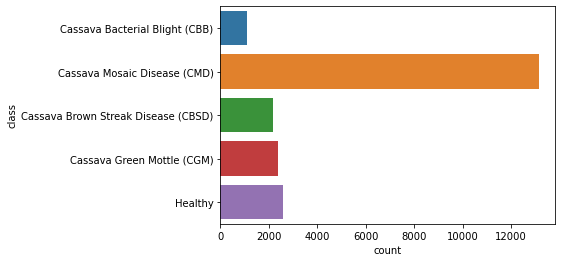

In [5]:
import seaborn as sns
sns.countplot(data=train_data, y ="class")

## 1.4 이미지 살펴보기
- os.listdir()
    - 디렉토리 내 모든 파일과 디렉토리 리스트를 리턴한다.

In [6]:
import os 
path = "../input/cassava-leaf-disease-classification/train_images"
images = os.listdir(path)
print("# Image :", len(images))

# Image : 21397


- dict.get(a, b) : key a에 해당하는 value를 반환
    - a : 찾으려는 key
    - b : 없을 경우 리턴할 값

In [7]:
import cv2
shape = {}
for image in images[:300]:
    img = cv2.imread(f"{path}/{image}")
    shape[img.shape] = shape.get(img.shape, 0) + 1
print(shape)

{(600, 800, 3): 300}


# 2. 모델링

## 2.1 데이터 로더 만들기
- path 에서 img array 를 추출하기 위해, custom dataloader를 사용했습니다.


In [8]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence

class Dataloader(Sequence):
    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = [cv2.imread(x[i]) for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [9]:
train_data['path'] = train_data['image_id'].map(lambda x : f"../input/cassava-leaf-disease-classification/train_images/{x}")
train_data.head(3)
train_data.describe()

,label
count,21397.000000
mean,2.651914
std,0.988565
min,0.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,4.000000


## 2.2 데이터 셋 만들기

In [10]:
from sklearn.model_selection import train_test_split
x = train_data['path'].array
y = train_data['label'].array

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=34)
train_loader = Dataloader(x_train, y_train, 16, shuffle=True)
valid_loader = Dataloader(x_test, y_test, 16)


## 2.3 레이어 쌓기

In [11]:
import tensorflow as tf

data_augmentation_layers = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), #랜덤으로 이미지를 좌우로 뒤집어줌.
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25), #이미지를 좌우로 25% 이내로 랜덤으로 돌립니다. 
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0)), #이미지를 0~20%만큼 랜덤으로 축소합니다.
        
    ]
)

SOTA 모델인 EfficientNet을 사용해보겠습니다.
- https://paperswithcode.com/sota/image-classification-on-imagenet
- https://keras.io/api/applications/efficientnet/

In [12]:
import tensorflow as tf

mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False, weights='imagenet', input_shape=(600,800,3)
)
mobile_net.trainable=True
'''
efficient_net = tf.keras.applications.EfficientNetB7(
    include_top=False, weights='imagenet', input_shape=(600,800,3)
)
efficient_net.trainable=True
'''

9412608/9406464 [==============================] - 0s 0us/step


"\nefficient_net = tf.keras.applications.EfficientNetB7(\n    include_top=False, weights='imagenet', input_shape=(600,800,3)\n)\nefficient_net.trainable=True\n"

- sparse_categorical_crossentropy : label
- categorical_crossentropy : one_hot

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D, Flatten
from tensorflow.keras import layers

model = Sequential() 
model.add(Input(shape=(600,800,3)))
model.add(data_augmentation_layers) 
model.add(mobile_net) 
#model.add(efficient_net) 
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5)) 
model.add(Flatten())
model.add(Dense(5, activation="softmax"))
model.summary()
model.trainable=True

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 600, 800, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 19, 25, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_______________________________________

- check point

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = [ModelCheckpoint(filepath='./model.h5', monitor='val_loss', save_best_only=True), EarlyStopping(monitor='val_loss', patience = 5, verbose=1)]

# 3. 학습시키기

In [15]:
# model = tf.keras.models.load_model("./model.h5")
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history  = model.fit(train_loader, validation_data=valid_loader, epochs=100, workers=8, callbacks=callbacks)
# model.save("./model.h5")

Epoch 1/100
937/937 [==============================] - 785s 829ms/step - loss: 1.2611 - acc: 0.5986 - val_loss: 1.2306 - val_acc: 0.6234
Epoch 2/100
937/937 [==============================] - 775s 826ms/step - loss: 1.2165 - acc: 0.6083 - val_loss: 1.2121 - val_acc: 0.6234
Epoch 3/100
937/937 [==============================] - 778s 830ms/step - loss: 1.2215 - acc: 0.6084 - val_loss: 1.1886 - val_acc: 0.6234
Epoch 4/100
937/937 [==============================] - 775s 826ms/step - loss: 1.2028 - acc: 0.6086 - val_loss: 1.1776 - val_acc: 0.6234
Epoch 5/100
937/937 [==============================] - 770s 822ms/step - loss: 1.2002 - acc: 0.6111 - val_loss: 1.2914 - val_acc: 0.6234
Epoch 6/100
937/937 [==============================] - 777s 829ms/step - loss: 1.2034 - acc: 0.6112 - val_loss: 1.1689 - val_acc: 0.6234
Epoch 7/100
937/937 [==============================] - 780s 832ms/step - loss: 1.2012 - acc: 0.6108 - val_loss: 1.1728 - val_acc: 0.6234
Epoch 8/100
937/937 [====================

# 4. 제출하기

In [16]:
import numpy as np
# model = tf.keras.models.load_model("./model.h5")
test_image = cv2.imread("../input/cassava-leaf-disease-classification/test_images/2216849948.jpg")
result = model.predict(np.array([test_image]))
print(np.argmax(result))

3


In [17]:
submission = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
submission["label"] = np.argmax(result)
submission.to_csv('submission.csv', index=False)